In [29]:
import torch
from torchvision import transforms
import yaml
from Pneumonia_predictor import PneumoniaDataset, PneumoniaPredictorCNN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.tensorboard.writer import SummaryWriter
from datetime import datetime
import logging
from helper_funcs import init_writer
from Trainer import Trainer
from pathlib import Path

In [23]:
logging.basicConfig(level=logging.INFO)

# Load the configuration file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [24]:
# load data
train_data_df = pd.read_csv(f'{config["data_dir"]}/train_data.csv')
val_data_df = pd.read_csv(f'{config["data_dir"]}/val_data.csv')
test_data_df = pd.read_csv(f'{config["data_dir"]}/test_data.csv')


In [25]:
image_size = config['image_size']

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [26]:
train_dataset = PneumoniaDataset(train_data_df, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers= config['num_workers'])

val_dataset = PneumoniaDataset(val_data_df, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers= config['num_workers'])

test_dataset = PneumoniaDataset(test_data_df, transform=val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers= config['num_workers'])

batch image shape: torch.Size([4, 1, 512, 512])
batch label shape: torch.Size([4])


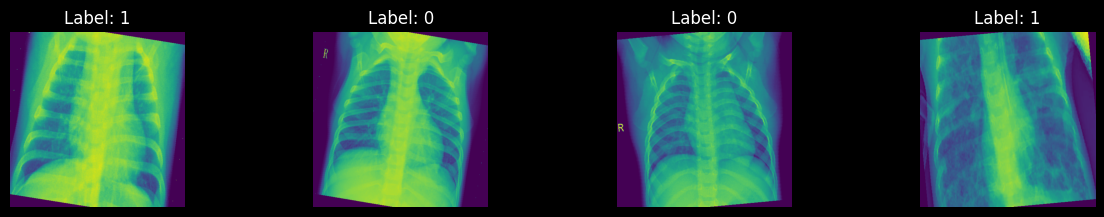

In [27]:
# Display a batch of images
def show_batch(images, labels):
    plt.figure(figsize=(15, 5))
    config = min(8, len(images))  # Limit to 8 images for display
    for i in range(config):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Quick test to see if the dataset and dataloader are working
images, labels = next(iter(train_loader))
print(f'batch image shape: {images.shape}')
print(f'batch label shape: {labels.shape}')

show_batch(images, labels)

In [28]:
model = PneumoniaPredictorCNN(image_size=(image_size, image_size))
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

timestamp = datetime.now().strftime('%d_%m_%H%M%S')
run_identifier = (
        f"{config['model_name']}"
        f"_bs{config['batch_size']}"
        f"_lr{config['learning_rate']}"
    )

run_name = f"{timestamp}_{run_identifier}"

config['run_name'] = run_name
writer = init_writer(config)

trainer = Trainer(model, optimizer, loss_fn, scheduler, config, device, writer, logging)
trainer.train(train_loader, val_loader, epochs=config['epochs'])

Flattened size after conv layers: 23040  160 channels x 12 H x 12 W)


INFO:root:Starting training...
INFO:root:Epoch 0: train_loss: 0.3954 | val_loss: 0.8727                                                                                                                                                                    
INFO:root:Epoch 0: New best validation loss: 0.8727. Model saved.
INFO:root:Epoch 1: train_loss: 0.3303 | val_loss: 0.6488                                                                                                                                                                    
INFO:root:Epoch 1: New best validation loss: 0.6488. Model saved.
INFO:root:Epoch 2: train_loss: 0.2992 | val_loss: 1.2597                                                                                                                                                                    
INFO:root:Epoch 3: train_loss: 0.2876 | val_loss: 0.4308                                                                                                                      

In [33]:
model = PneumoniaPredictorCNN(image_size=(image_size,image_size))
model.to(device)

# 3) Load weights
checkpoint_path = Path("output/models/best_model.pth")  # or final_model.pth
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# 5) Run evaluation
correct = 0
total   = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                   # shape [B, 2]
        preds   = outputs.argmax(dim=1)           # class indices 0 or 1

        correct += (preds == labels).sum().item()
        total   += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Flattened size after conv layers: 23040  160 channels x 12 H x 12 W)
Test Accuracy: 79.17%
